### dependencies setups

In [1]:
import tensorflow as tf
import numpy as np
import itertools
from tensorflow.python.keras import backend as Keras
from abc import *
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
import os
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from importlib import reload
import utils
reload(utils)
import pandas as pd
import math
import datetime

# global parameter setting
TRAIN_DATA_PATH = './siamese-nn-files/all/train-temp.csv'
TRAIN_SINGLE_DATA_ITER = 1024
TRAIN_DATA_COL_NAME = ['id', 'qid1', 'qid2', 'question1', 'question2', 'label']

TEST_DATA_PATH = './siamese-nn-files/all/test-temp.csv'
TEST_SINGLE_DATA_ITER = 1024
TEST_DATA_COL_NAME = ['id', 'qid1', 'qid2', 'question1', 'question2', 'label']

train_data_max_epoch = 5

USING_PRE_TRAINED_VECTOR = True
USE_CHAR_EMBEDDING = False
USE_LSTM_CELL = True

DROPOUT_PERCENTILE = 1

train_df = pd.read_csv(TRAIN_DATA_PATH, dtype=str).astype(str)
test_df = pd.read_csv(TEST_DATA_PATH, dtype=str).astype(str)
train_df_length = len(train_df.index)
test_df_length = len(test_df.index)

train_df_q1 = train_df['question1'].astype(str)
train_df_q2 = train_df['question2'].astype(str)
test_df_q1 = test_df['question1'].astype(str)
test_df_q2 = test_df['question2'].astype(str)

TRAIN_DATA_MAX_ITER = math.floor(train_df_length / TRAIN_SINGLE_DATA_ITER)
TEST_DATA_MAX_ITER = math.floor(test_df_length / TEST_SINGLE_DATA_ITER)

# limits to max 50 chars/words from front
MAX_CHAR_LENGTH = 50
MAX_WORD_LENGTH = 50

RNN_DIMENSION = [50]

### content prep. for building char / word - level dics

In [2]:
whole_content_list = []
for content_list in [train_df['question1'],train_df['question2'],test_df['question1'],test_df['question2']]:
    for content in content_list:
        content = str(content)
        whole_content_list.append(content)

### char-level dic. building

In [3]:
uniq_char_lst, uniq_chars_index = utils._get_char_idx_mapping(whole_content_list)
vocab_num = len(uniq_char_lst)

### word-level dic. building

In [4]:
reload(utils)
uniq_word_lst, uniq_words_index = utils._get_word_idx_mapping(whole_content_list)
word_num = len(uniq_words_index)

### pre-trained word embedding integration

In [13]:
cwd = os.getcwd()
glove_file = datapath(cwd+'/siamese-nn-files/glove.840B.300d.txt')
tmp_file = get_tmpfile(cwd+"/siamese-nn-files/glove.840B.300d-w2v.txt")
glove2word2vec(glove_file, tmp_file)

(2196018, 300)

In [14]:
w2v_model = KeyedVectors.load_word2vec_format(tmp_file)

In [15]:
glove_embedding_matrix = np.zeros((len(word_num) + 1, 300)) # +1 for <unk> word

for word, idx in uniq_words_index.items():
    try:
        glove_embedding_matrix[idx] = w2v_model[word]
    except KeyError:
        glove_embedding_matrix[idx] = w2v_model['<unk>']

print(glove_embedding_matrix)

[[-0.26554     0.33531001  0.2186     ... -0.17859    -0.062878
   0.16232   ]
 [-0.44466999  0.69536     0.42748001 ... -0.079391   -0.52717
  -0.12413   ]
 [-0.60711998  0.42544001  0.5104     ... -0.18588001  0.025965
  -0.48231   ]
 ...
 [-0.07969    -0.22905     0.80365998 ... -0.083561    0.48532
  -0.7313    ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


### data fetcher

In [5]:
reload(utils)
def labled_data_fetcher(df, current_iter, UNIT):
    
    start_idx = current_iter * UNIT
    end_idx = (current_iter+1) * UNIT
    current_data = df[start_idx:end_idx]
    id = current_data['id']
    qid1 = current_data['qid1']
    qid2 = current_data['qid2']
    question1_lst = current_data['question1']
    question2_lst = current_data['question2']
    label = current_data['is_duplicate']

    return {
        "q1_char_lst": utils.preproc_char(question1_lst, uniq_chars_index, MAX_CHAR_LENGTH), 
        "q2_char_lst": utils.preproc_char(question2_lst, uniq_chars_index, MAX_CHAR_LENGTH),
        "q1_char_len_lst": utils._get_char_length_list(question1_lst, MAX_CHAR_LENGTH),
        "q2_char_len_lst": utils._get_char_length_list(question2_lst, MAX_CHAR_LENGTH),
        "q1_word_lst": utils.preproc_word(question1_lst, uniq_words_index, MAX_WORD_LENGTH),
        "q2_word_lst": utils.preproc_word(question2_lst, uniq_words_index, MAX_WORD_LENGTH),
        "q1_word_len_lst": utils._get_word_length_list(question1_lst, MAX_WORD_LENGTH),
        "q2_word_len_lst": utils._get_word_length_list(question2_lst, MAX_WORD_LENGTH),
        "label": label
    }  

### siamese network impl.

In [ ]:
reload(utils)
class SiameseNetwork(object):
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.name_scope('input'):
                self.q1 = tf.placeholder(tf.int32, shape=(None, MAX_CHAR_LENGTH))
                self.q2 = tf.placeholder(tf.int32, shape=(None, MAX_CHAR_LENGTH))
                
                
                self.q1_word_lst = tf.placeholder(tf.int32, shape=(None, MAX_WORD_LENGTH))
                self.q2_word_lst = tf.placeholder(tf.int32, shape=(None, MAX_WORD_LENGTH))
                

                self.is_dup = tf.placeholder(tf.int32, shape=(None))
                self.q1_length_lst = tf.placeholder(tf.int32, shape=(None))
                self.q2_length_lst = tf.placeholder(tf.int32, shape=(None))   
                self.q1_word_len_lst = tf.placeholder(tf.int32, shape=(None))   
                self.q2_word_len_lst = tf.placeholder(tf.int32, shape=(None))   
                
                           
            with tf.name_scope('embedding'):
                embedding_matrix_char = tf.Variable(tf.random_uniform([vocab_num+2, 300], -1.0, 1.0))
                
                if USING_PRE_TRAINED_VECTOR is True:
                    w2v_template = tf.Variable(tf.constant(0.0, shape=[len(glove_embedding_matrix), 300]),
                trainable=False, name="w2v")
                    self.embedding_matrix = tf.get_variable(name="w2v", shape=glove_embedding_matrix.shape, initializer=tf.constant_initializer(glove_embedding_matrix), trainable=False)
                    embedding_matrix_fin = w2v_template.assign(self.embedding_matrix)
                else:
                    embedding_matrix_fin = tf.Variable(tf.random_uniform([word_num+2, 300], -1.0, 1.0))

                
                # embedding lookup for chars (using rand. embeddings)
                self.q1_e = tf.nn.embedding_lookup(embedding_matrix_char, self.q1)
                self.q2_e = tf.nn.embedding_lookup(embedding_matrix_char, self.q2)
                
                # embedding lookup for words (using pre-trained embeddings)
                self.q1_word_e = tf.nn.embedding_lookup(embedding_matrix_fin, self.q1_word_lst)
                self.q2_word_e = tf.nn.embedding_lookup(embedding_matrix_fin, self.q2_word_lst)
                
            with tf.name_scope('output'):          
                
                # WIP (current default is word embedding ONLY.)
                if USE_CHAR_EMBEDDING is True:
                    input_tensor_q1 = tf.concat([self.q1_e,self.q1_word_e], axis=-1)
                    input_tensor_q2 = tf.concat([self.q2_e,self.q2_word_e], axis=-1)
                    input_tensor_q1_length = self.q1_length_lst+self.q1_word_len_lst
                    input_tensor_q2_length = self.q2_length_lst+self.q2_word_len_lst
                    
                else:
                    input_tensor_q1 = self.q1_word_e
                    input_tensor_q2 = self.q2_word_e
                    input_tensor_q1_length = self.q1_word_len_lst
                    input_tensor_q2_length = self.q2_word_len_lst
                    
                
                _, self.q1_tensor = self.nn_layer(
                    input_tensor_q1,
                    input_tensor_q1_length
                )    

                _, self.q2_tensor = self.nn_layer(
                    input_tensor_q2,
                    input_tensor_q2_length,
                    reuse=True
                )

                
            with tf.name_scope('loss'):
                # print tensor input made from final state of RNN 
                self.q1_tensor = tf.Print(self.q1_tensor, [self.q1_tensor], "self.q1_tensor", summarize=30)

                # Manhattan Distance Calc: absolute exponented diff. between two vector for similarity measures (in a range of 0 ~ 1)
                self.pred_sim = tf.exp(0.0 - tf.reduce_sum(tf.abs(self.q1_tensor - self.q2_tensor), 1))
                
                # print Manhattan Distance results AND its answers
                self.pred_sim = tf.Print(self.pred_sim, [self.pred_sim], "self.pred_sim", summarize=30)
                self.is_dup = tf.Print(self.is_dup, [self.is_dup], "self.is_dup", summarize=30)
                
                # print MSE losses for each iteration
                mse = tf.losses.mean_squared_error(self.is_dup, self.pred_sim)
                mse = tf.Print(mse, [mse], "MSE :")
                self.loss = mse
                

            with tf.name_scope('optimizer'):
                # perform SGD for minimise total MSE loss
                self.traning_op = tf.train.AdamOptimizer().minimize(self.loss)

            with tf.name_scope('accuracy'):
                # 0.5 as a threshold value for classification
                # mark correct predictions
                pos_class_result = tf.equal(tf.greater_equal(self.pred_sim, 0.5), tf.equal(self.is_dup, 1))
                neg_class_result = tf.equal(tf.less(self.pred_sim, 0.5), tf.equal(self.is_dup, 0))
                pos_class_result = tf.reshape(tf.cast(pos_class_result, tf.float32), [-1])
                neg_class_result = tf.reshape(tf.cast(neg_class_result, tf.float32), [-1])
                
                # get acc. (proportion of correct prediction over total predictions)
                acc_result = tf.keras.backend.concatenate([pos_class_result, neg_class_result])
                self.accuracy = tf.reduce_mean(acc_result)
                
            self.init = tf.global_variables_initializer()

    @abstractmethod
    def nn_layer(self, e):
        pass

    def run(self, sess, mode, fetched_data):

        feed_dict = {
            self.q1: fetched_data["q1_char_lst"],
            self.q2: fetched_data["q2_char_lst"],
            self.q1_length_lst: fetched_data["q1_char_len_lst"],
            self.q2_length_lst: fetched_data["q2_char_len_lst"],
            self.q1_word_lst: fetched_data["q1_word_lst"],
            self.q2_word_lst: fetched_data["q2_word_lst"],
            self.q1_word_len_lst: fetched_data["q1_word_len_lst"],
            self.q2_word_len_lst: fetched_data["q2_word_len_lst"],
            self.is_dup: fetched_data["label"]   
        }   

        if mode is "train":
            _, _, loss, acc = sess.run([self.q1, self.traning_op, self.loss, self.accuracy], feed_dict=feed_dict) 
            return loss, acc
        
        if mode is "test":
            loss, acc = sess.run([self.loss, self.accuracy], feed_dict=feed_dict)
            return loss, acc
        

class SiameseRNN(SiameseNetwork):
    
    def nn_layer(self, embeddings, lengths, reuse=False):
            with tf.name_scope('feed'):
                
                # construct and set rnn cells from given spec.
                if USE_LSTM_CELL is True:
                    cells = [tf.nn.rnn_cell.LSTMCell(num_units=n, reuse=reuse, state_is_tuple=True) for n in RNN_DIMENSION]
                else:
                    cells = [tf.nn.rnn_cell.GRUCell(num_units=n, reuse=reuse) for n in RNN_DIMENSION]
                    
                cells = list(map(lambda cell: tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PERCENTILE), cells))

                rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
                initial_state = rnn_cell.zero_state(batch_size=tf.shape(embeddings)[0], dtype=tf.float32)
                sequence_length = lengths + 2
                
                output, state = tf.nn.dynamic_rnn(rnn_cell, 
                                                  embeddings, 
                                                  initial_state=initial_state,
                                                  sequence_length=sequence_length)
                
                if USE_LSTM_CELL is True:
                    return output, state[-1][0] # in last LSTM tuple, get hidden state (index 1)
                else:
                    return output, state[len(RNN_DIMENSION)-1]



def train_and_test_model():
    model = SiameseRNN()
    with tf.Session(graph=model.graph) as sess:
        sess.run(model.init)
        train_data_current_iter = 0
        train_data_current_epoch = 0        
        test_data_current_iter = 0
        
        print('------info------')
        print('timestamp                : {}'.format(datetime.datetime.now()))
        print('train_data_max_epoch     : {}'.format(train_data_max_epoch))
        print('train_df_length          : {}'.format(train_df_length))
        print('test_df_length           : {}'.format(test_df_length))
        print('TRAIN_DATA_MAX_ITER      : {}'.format(TRAIN_DATA_MAX_ITER))
        print('TEST_DATA_MAX_ITER       : {}'.format(TEST_DATA_MAX_ITER))
        print('TRAIN_SINGLE_DATA_ITER   : {}'.format(TRAIN_SINGLE_DATA_ITER))
        print('TEST_SINGLE_DATA_ITER    : {}'.format(TEST_SINGLE_DATA_ITER))
        print('RNN_DIMENSION            : {}'.format(RNN_DIMENSION))
        print('DROPOUT_PERCENTILE       : {}'.format(DROPOUT_PERCENTILE))
        print('USING_PRE_TRAINED_VECTOR : {}'.format(USING_PRE_TRAINED_VECTOR))
        print('USE_CHAR_EMBEDDING       : {}'.format(USE_CHAR_EMBEDDING))
        print('USE_LSTM_CELL            : {}'.format(USE_LSTM_CELL))
        print('')
        
        # iterate until defined epoch
        for i in range(train_data_max_epoch-1):
            train_data_current_epoch = train_data_current_epoch + 1
            
            for j in range(TRAIN_DATA_MAX_ITER):
                loss, acc = model.run(sess, "train", labled_data_fetcher(train_df, j, TRAIN_SINGLE_DATA_ITER))
                train_loss.append(loss)
                train_acc.append(acc)
                train_data_current_iter += 1
                print('[{}] TRAIN [ {} - {} ] loss: {} / acc.: {}'.format(datetime.datetime.now(), train_data_current_epoch, train_data_current_iter, loss, acc))
            train_data_current_iter = 0

        for k in range(TEST_DATA_MAX_ITER):
            loss, acc = model.run(sess, "test", labled_data_fetcher(test_df, k, TEST_SINGLE_DATA_ITER))
            test_loss.append(loss)
            test_acc.append(acc)
            test_data_current_iter += 1
            print('[{}] TEST  [ {} ] loss: {} / acc.: {}'.format(datetime.datetime.now(), test_data_current_iter, loss, acc))

# data store for losses and acc.
train_loss = []
train_acc = []
test_loss = []
test_acc = []

train_and_test_model()

<IPython.core.display.Javascript object>


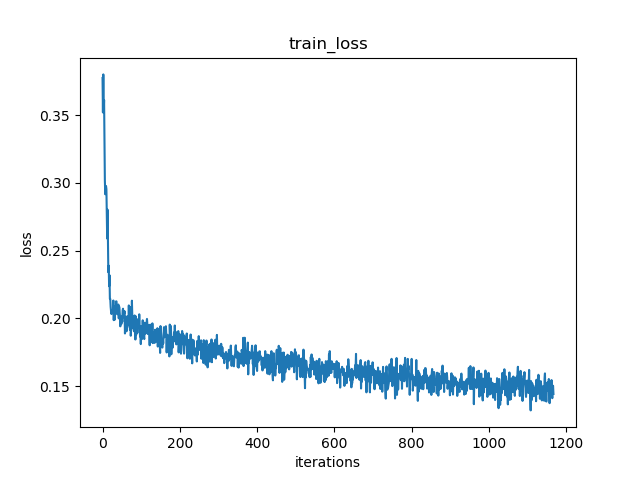

<IPython.core.display.Javascript object>


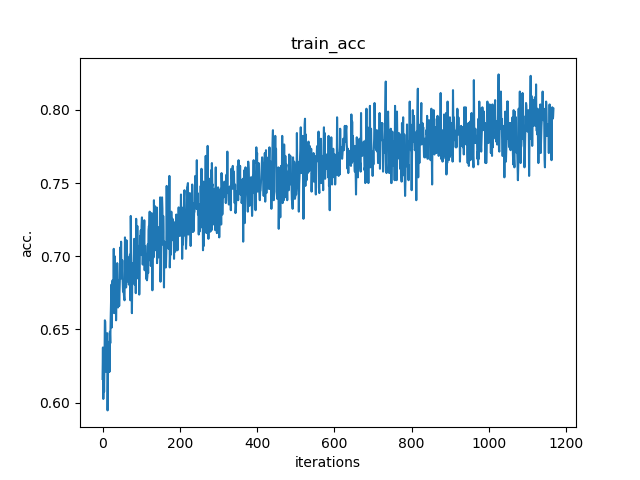

In [78]:
%matplotlib notebook
import matplotlib.pyplot as plt
plot, axis = plt.subplots()
axis.plot(train_loss)
axis.set_title('train_loss')
axis.set_xlabel('iterations')
axis.set_ylabel('loss')
plot.show()

plot, axis = plt.subplots()
axis.plot(train_acc)
axis.set_title('train_acc')
axis.set_xlabel('iterations')
axis.set_ylabel('acc.')
plot.show()

<IPython.core.display.Javascript object>


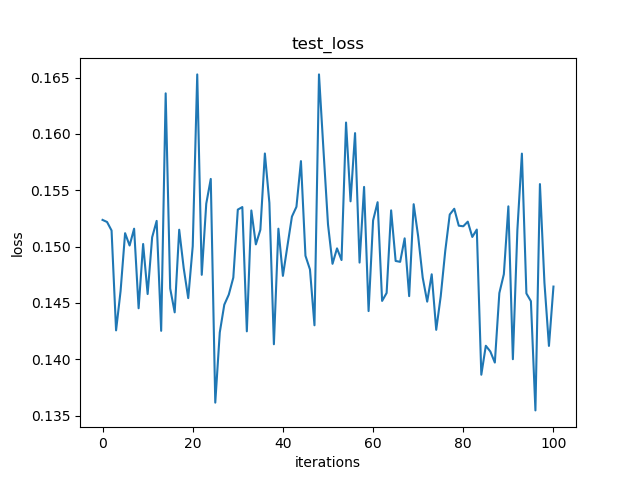

<IPython.core.display.Javascript object>


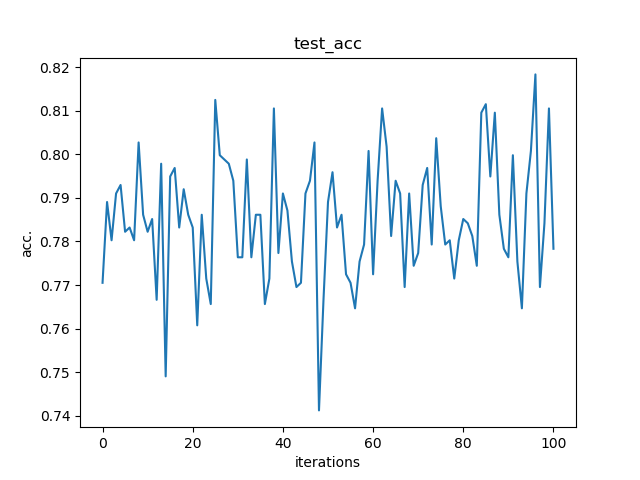

In [79]:
plot, axis = plt.subplots()
axis.plot(test_loss)
axis.set_title('test_loss')
axis.set_xlabel('iterations')
axis.set_ylabel('loss')
plot.show()

plot, axis = plt.subplots()
axis.plot(test_acc)
axis.set_title('test_acc')
axis.set_xlabel('iterations')
axis.set_ylabel('acc.')
plot.show()

In [ ]:
print("train_loss")
print(train_loss)
print("train_acc")
print(train_acc)
print("test_loss")
print(test_loss)
print("test_acc")
print(test_acc)